# Import Packages

In [1]:
import pandas  as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns 

from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)

%matplotlib inline

# Import Data
We are going to work with the Boston Housing dataset which contains information collected by the U.S Census Service concerning housing in the area of Boston. Our ojective is to train a model that can predict housing prices based on a number of predictors, such as crime rate, average number of rooms per dwelling, pupil-teacher ratio..etc. You can find the full description of the dataset here: https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

In [2]:
# Load the dataset using the ISLP package which is a companion package that comes with the book "Introduction to Statistical Learning"
df = load_data("Boston")
df.head(3)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7


# Data Exploration
Let's quickly look at null values and data types:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  lstat    506 non-null    float64
 12  medv     506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


The dataset does not contain any missing (null) values. Next, we'll examine the statistical summary of the numerical columns using the .describe() method:

In [4]:
df.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


Now we have a better understanding of the possible values and range of each variable, as well as their spread. This also helps us determine whether a variable is continuous or categorical.
Next, we'll examine the correlation between the dependent variable "medv" and the predictor variables. We're looking for strong correlations here, as a higher correlation with the target variable generally indicates a greater potential for predictive power:

Absolute corrolation with the target:
chas       0.175260
dis        0.249929
zn         0.360445
age        0.376955
rad        0.381626
crim       0.388305
nox        0.427321
tax        0.468536
indus      0.483725
ptratio    0.507787
rm         0.695360
lstat      0.737663
medv       1.000000
Name: medv, dtype: float64


<Axes: >

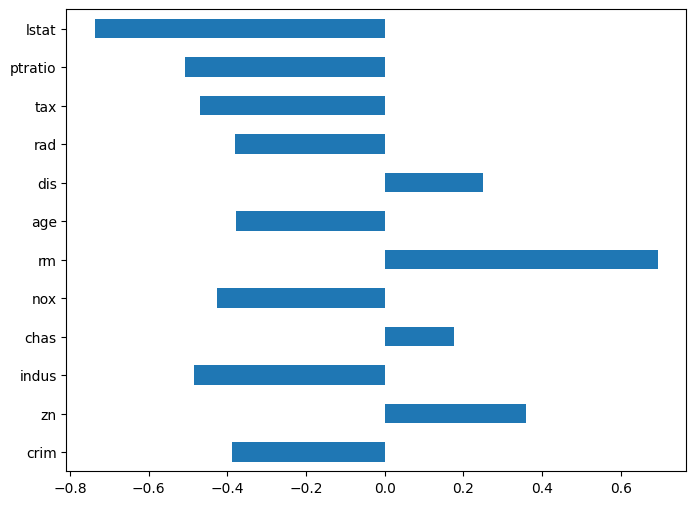

In [5]:
# Compute correlation with target as absolute numbers
correlation = df.corr()['medv'].abs()
print('Absolute corrolation with the target:')
print(correlation.sort_values())

# Compute correlation with target in the form of bar chart
correlation = df.corr()['medv']
correlation.drop('medv').plot(kind='barh', figsize=(8, 6))

I’m going to select the predictor variables that have a correlation with the dependent variable "medv" greater than or equal to a specified threshold:

In [6]:
# Keep variables with absolute correlation greater than a threshold
threshold_corrolation = .2
# threshold_corrolation =0
columns_to_keep = correlation[abs(correlation) >= threshold_corrolation].index

df_filtered = df[columns_to_keep]
df_filtered.sample()

,crim,zn,indus,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
188,0.12579,45.0,3.44,0.437,6.556,29.1,4.5667,5,398,15.2,4.56,29.8


Let's look at the corrolation heatmap:

Text(0.5, 1.0, 'Correlation Heatmap (|Correlation| ≥ 0.2)')

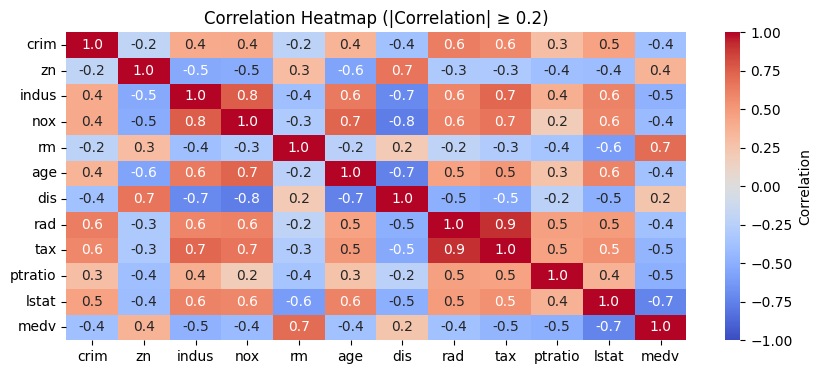

In [7]:
# Calculate correlation matrix
corr = df_filtered.corr()

# Plot heatmap with the mask
plt.figure(figsize=(10,4))
sns.heatmap(corr, annot=True, fmt=".1f", cmap='coolwarm', 
            vmin=-1, vmax=1, center=0, cbar_kws={'label': 'Correlation'})
plt.title(f"Correlation Heatmap (|Correlation| ≥ {threshold_corrolation})")

From the corrolation heatmap, we notice the following:
- The most corrolated variables with the target are lstat and rm with values -0.7 and 0.7 respectivly showing strong potential in predicting the target variable.
- We notice colinearity between some pairs on independant variables (look at 'indus', 'nox', 'crim' columns) we will remove them as collinearity can introduce confusion to the regression model.

In [8]:
df_filtered = df_filtered.drop(columns=['indus', 'nox', 'crim'])

Now we'll use a pair plot to visualize the distributions of the variables and the relationships between them. This helps us detect collinearity and assess whether the data appears to be normally distributed:

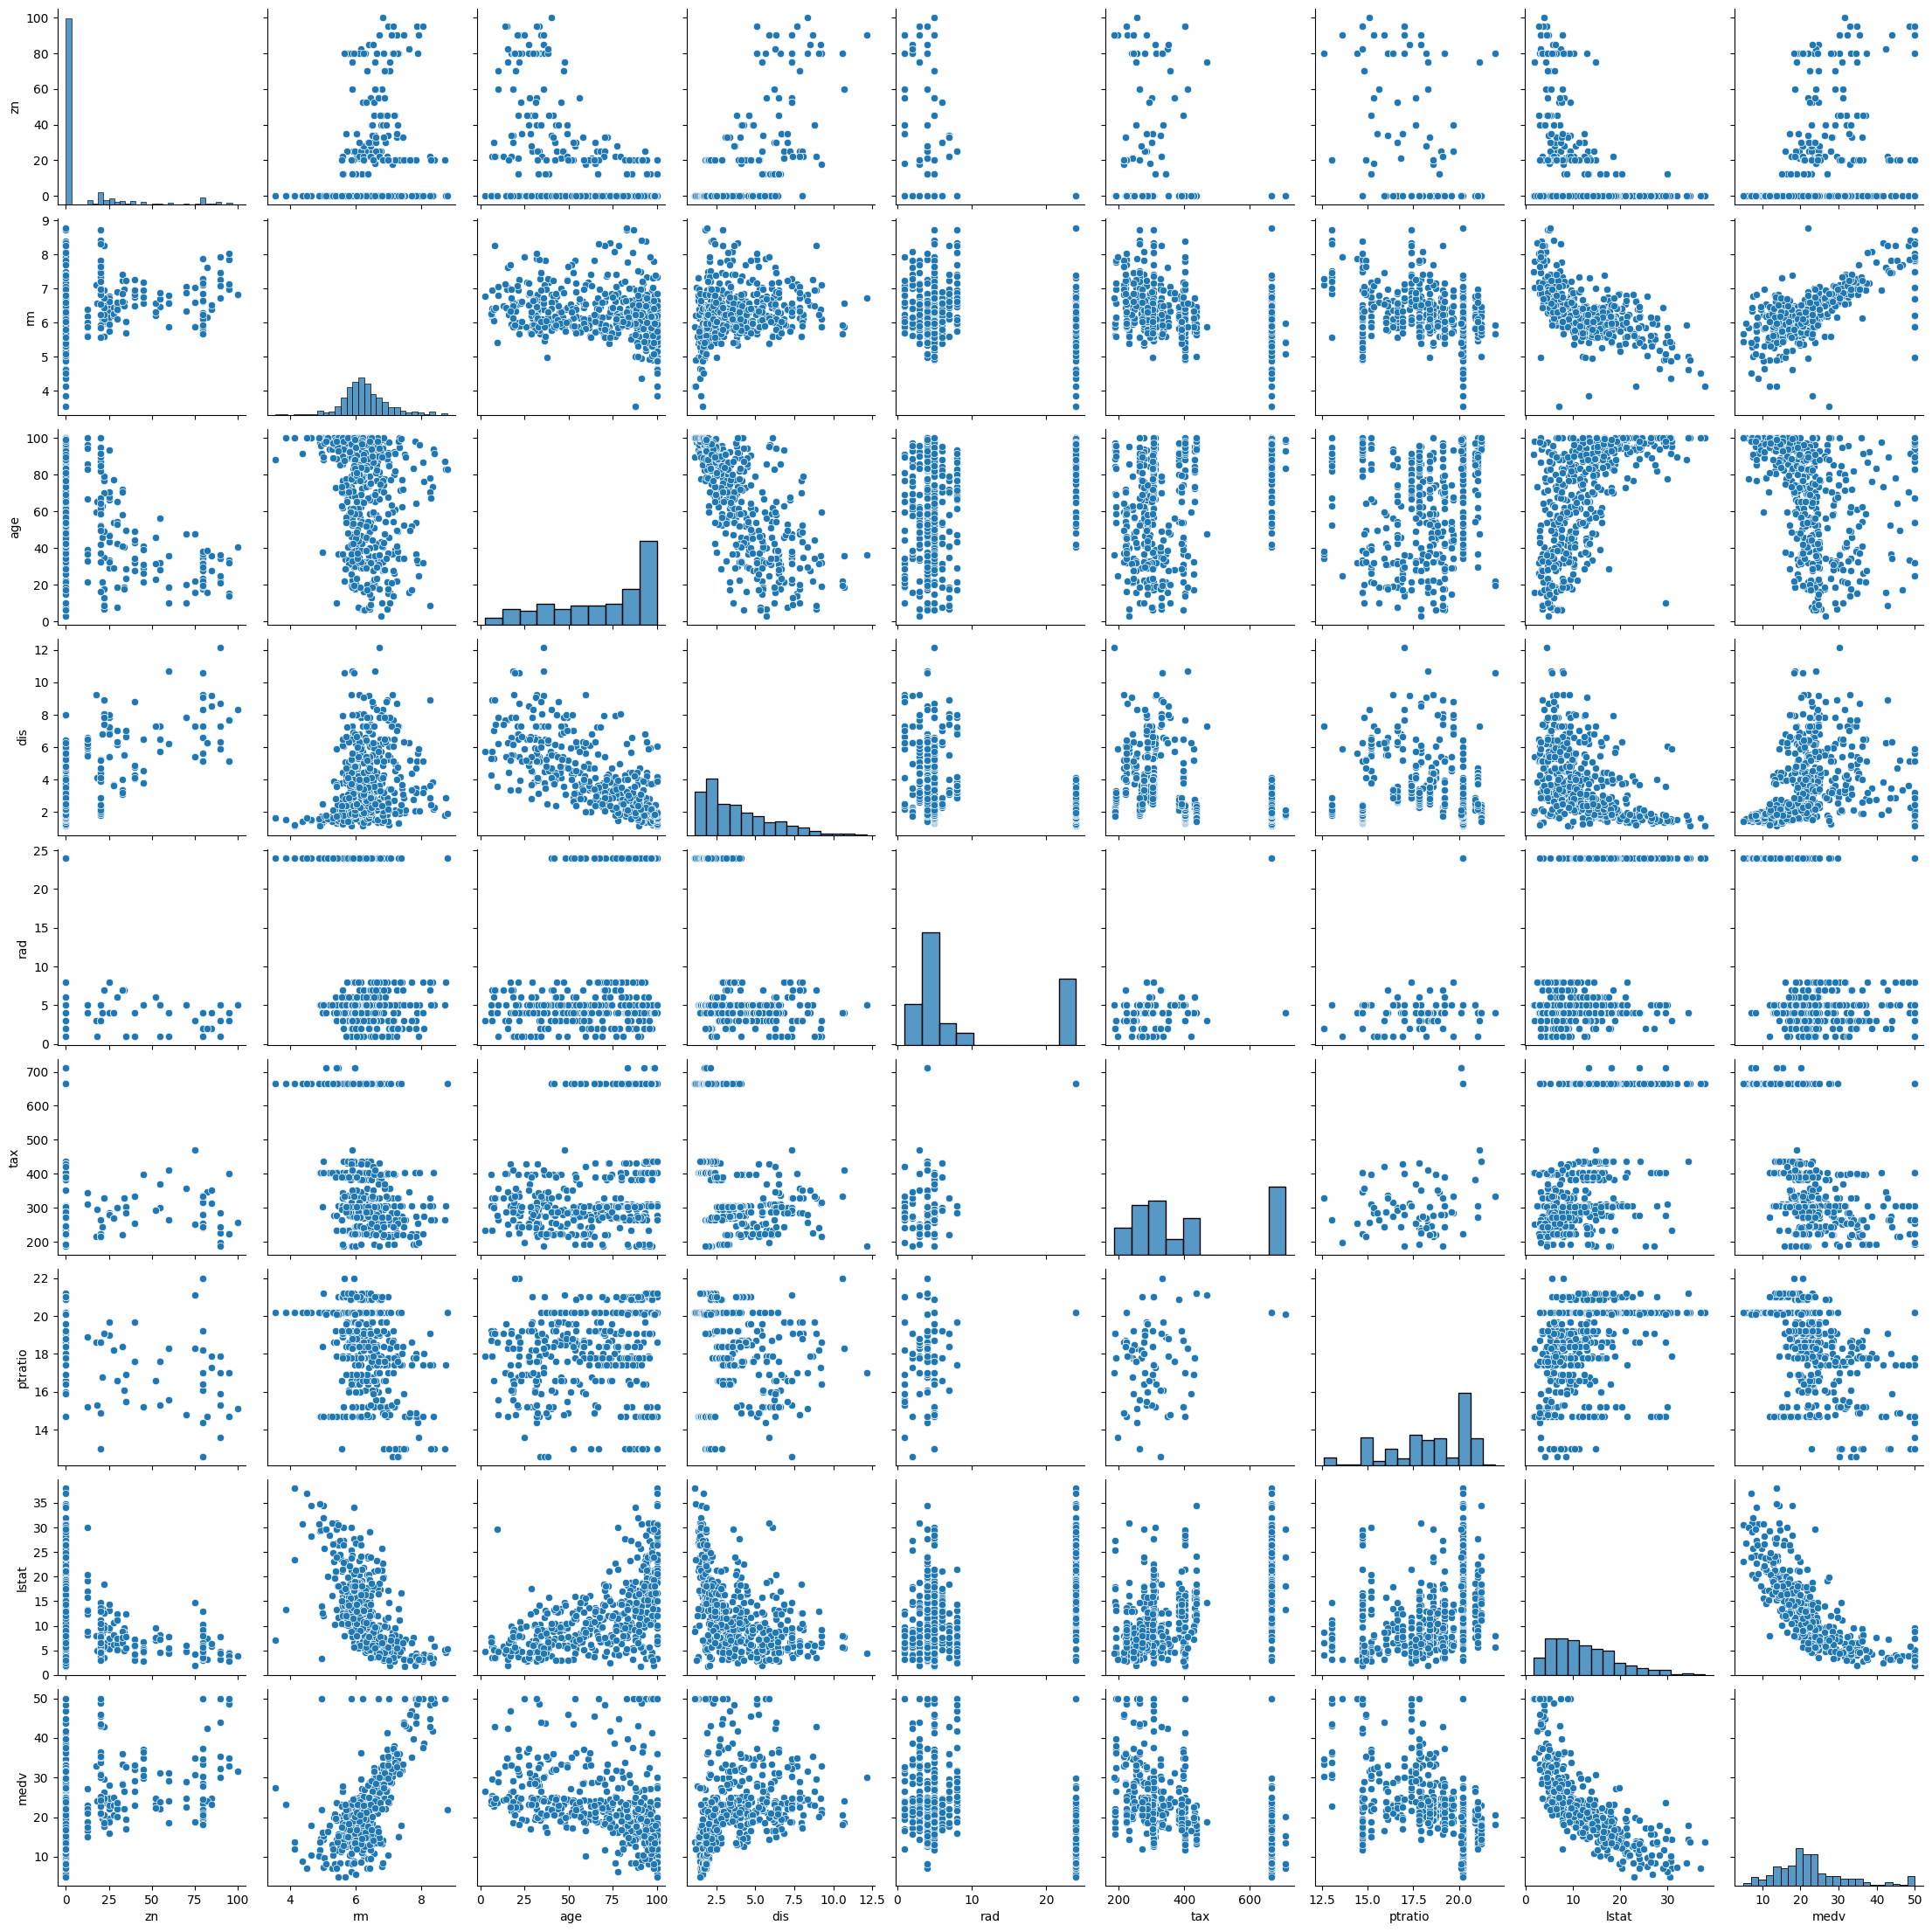

In [9]:
# pairplot to identify categorical variables, colinearity, and distributions
sns.pairplot(df_filtered)

# Data pre-processing and Feature Engineering

### Create interaction terms
After some experimentation, I created an interaction term and centered the variables involved to avoid a high Variance Inflation Factor (VIF). Centering helps reduce collinearity between the individual variables and their interaction term, which in turn improves model stability:

In [10]:
df_filterd_processed = df_filtered.copy()

# Specify interaction pairs as tuples in a list
interaction_pairs = [('rm', 'tax')]

# Center variables and create interaction terms.
# Centering before interacting to avoin high Variance Inflation Factor (VIF)
for var1, var2 in interaction_pairs:
    # Center variables
    df_filterd_processed[f'{var1}_centered'] = df_filterd_processed[var1] - df_filterd_processed[var1].mean()
    df_filterd_processed[f'{var2}_centered'] = df_filterd_processed[var2] - df_filterd_processed[var2].mean()
    
    # Create interaction term
    interaction_name = f'interaction_{var1}_{var2}'
    df_filterd_processed.loc[:, interaction_name] = df_filterd_processed[f'{var1}_centered'] * df_filterd_processed[f'{var2}_centered']

    # Drop original column
    df_filterd_processed.drop(columns=[var1, var2], inplace= True)
    
# Show results
df_filterd_processed.head(2)

,zn,age,dis,rad,ptratio,lstat,medv,rm_centered,tax_centered,interaction_rm_tax
0,18.0,65.2,4.0900,1,15.3,4.98,24.0,0.290366,-112.237154,-32.589810
1,0.0,78.9,4.9671,2,17.8,9.14,21.6,0.136366,-166.237154,-22.669031


### One-hot encoding
The following code performs one-hot encoding on a list of categorical variables. In this case, we haven't selected any, but the code is included as a reusable template for different use cases where categorical variables may be present:

In [11]:
# Dummy variable
categorical_columns = []
df_filterd_processed = pd.get_dummies(data = df_filterd_processed, #prefix = 'OHE', prefix_sep='_',
               columns = categorical_columns,
               drop_first =True,
               dtype='int8')
df_filterd_processed.head(3)

,zn,age,dis,rad,ptratio,lstat,medv,rm_centered,tax_centered,interaction_rm_tax
0,18.0,65.2,4.0900,1,15.3,4.98,24.0,0.290366,-112.237154,-32.589810
1,0.0,78.9,4.9671,2,17.8,9.14,21.6,0.136366,-166.237154,-22.669031
2,0.0,61.1,4.9671,2,17.8,4.03,34.7,0.900366,-166.237154,-149.674217


### Transformation and scaling
Transforming some columns using the log function. Applying a log transformation normalizes the distribution of the variable, making linear regression assumptions more valid:

In [12]:
# from sklearn.preprocessing import MinMaxScaler
df_filterd_processed_scaled = df_filterd_processed.copy()

# List of columns to transform with log function
columns_to_log_transform = ['lstat']

# # Apply log transformation
df_filterd_processed_scaled[columns_to_log_transform] = np.log(df_filterd_processed_scaled[columns_to_log_transform])


### Split data into training and testing sets

In [13]:
# Columns to drop based on high p-values and VIF (after experimenting)
# columns_to_drop = ['dis', 'rad']
columns_to_drop = ['dis']

# Separate dependent variable
X = df_filterd_processed_scaled.drop('medv',axis=1) # Independet variables
y = df_filterd_processed_scaled['medv'] # dependent variable

# Drop columns based on p-value
X = X.drop(columns=columns_to_drop)
y= y.drop(columns=columns_to_drop)

# Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=23)

# Model building

Define a function for model evaluation:

In [14]:
def evaluate_models(models, X_test, y_test):
    n_models = len(models)
    fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 6))

    if n_models == 1:
        axes = [axes]  # Make it iterable if only 1 model

    # Step 1: Collect metrics first
    metrics = []
    for model in models:
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        metrics.append({'model': model, 'mse': mse, 'mae': mae, 'rmse': rmse, 'r2': r2})

    # Step 2: Find best scores
    best_r2 = max(m['r2'] for m in metrics)
    best_mse = min(m['mse'] for m in metrics)
    best_mae = min(m['mae'] for m in metrics)
    best_rmse = min(m['rmse'] for m in metrics)

    # Step 3: Plot and highlight
    for metric, ax in zip(metrics, axes):
        model = metric['model']
        mse = metric['mse']
        mae = metric['mae']
        rmse = metric['rmse']
        r2 = metric['r2']

        y_pred = model.predict(X_test)

        ax.scatter(y_test, y_pred)
        ax.set_xlabel('Actual Labels')
        ax.set_ylabel('Predicted Labels')

        model_name = type(model).__name__
        ax.set_title(f'{model_name}')

        # Regression line
        z = np.polyfit(y_test, y_pred, 1)
        p = np.poly1d(z)
        ax.plot(y_test, p(y_test), color='magenta')

        # Text positioning
        text_x = 0.05
        text_y = 0.95
        line_spacing = 0.08

        # Plot metrics one by one
        for i, (label, value, best_value, is_higher_better) in enumerate([
            ("R²", r2, best_r2, True),
            ("MSE", mse, best_mse, False),
            ("MAE", mae, best_mae, False),
            ("RMSE", rmse, best_rmse, False),
        ]):
            # Check if current value is the best
            is_best = (value == best_value)
            color = 'green' if is_best else 'black'
            weight = 'bold' if is_best else 'normal'
            ax.text(text_x, text_y - i * line_spacing,
                    f'{label}: {value:.3f}',
                    transform=ax.transAxes,
                    fontsize=12,
                    color=color,
                    fontweight=weight,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round,pad=0.4', facecolor='lightblue', alpha=0.5))

    plt.tight_layout()
    plt.show()


## Linear Regression

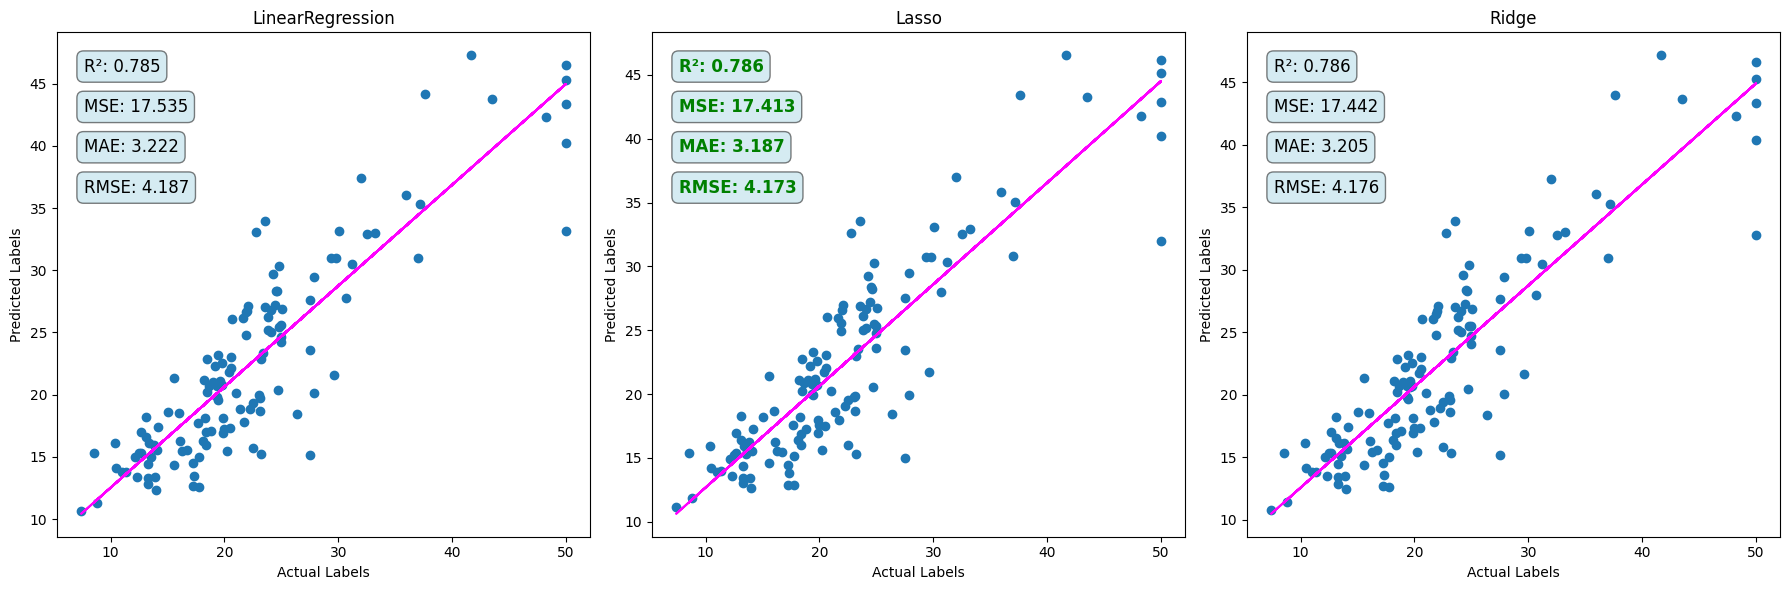

In [15]:
linear = LinearRegression()
lasso = Lasso(alpha=0.1)
ridge = Ridge(alpha=1.0)

# Fit the models
lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)
linear.fit(X_train, y_train)

# Print results
evaluate_models([linear, lasso, ridge], X_test, y_test)

We observe that the performance of Linear Regression, Lasso, and Ridge is almost identical, with Lasso showing a very slight improvement. This suggests that the dataset is relatively clean, with little noise or multicollinearity, and as a result, regularization (Lasso and Ridge) has minimal impact in this case. Now, let's examine the Lasso coefficients. Since Lasso applies L1 regularization, it tends to shrink the coefficients of less important features exactly to zero, effectively performing feature selection.

In [16]:
# Model coefficients
lasso_coeff = lasso.coef_

# Lasso coefficients tell us feature improtance, we well format it to switch from scientific notation to readable numbers
formatted_coeffs = np.array2string(lasso_coeff, suppress_small=True, precision=5, floatmode='fixed')
print(formatted_coeffs)

[-0.01850  0.02902  0.10124 -0.67943 -9.01815  3.10946 -0.01057 -0.01370]


It appears that all the included features are relevant; however, three features stand out with notably high coefficients, suggesting that they are the most important. Now, let's assess the statistical significance of these features by examining their p-values using OLS from Statsmodels. Spoiler alert: we expect the p-values to be low, as we didn’t observe any zero coefficients from the Lasso model, but let’s take a closer look

### Assess the statistical significance of the predictors (p-values)

In [17]:
# OLS model
model_OLS = sm.OLS(y_train, X_train)
results = model_OLS.fit()
summarize(results)

,coef,std err,t,P>|t|
zn,0.0704,0.017,4.261,0.000
age,0.0676,0.017,3.987,0.000
rad,0.2117,0.087,2.422,0.016
ptratio,1.3344,0.102,13.105,0.000
lstat,-4.4388,0.903,-4.914,0.000
rm_centered,6.5830,0.646,10.190,0.000
tax_centered,-0.0320,0.004,-7.250,0.000
interaction_rm_tax,-0.0207,0.003,-6.934,0.000


As expected, p-values are looking good and below the usual threshold .05

### Is there a relationship between the response and predictors? (F-statistic)

In [18]:
f_statistic = results.fvalue
print(f"F-statistic: {f_statistic:.2f}")
print('Largly greater than 1, which means at least one of the predictor has a relationship with the dependant variable')

F-statistic: 697.01
Largly greater than 1, which means at least one of the predictor has a relationship with the dependant variable


The F-statistic is significantly greater than 1, indicating that at least one of the predictors has a meaningful relationship with the dependent variable (just to increase our confidence in the modeling)

### Variance Inflation Factor (VIF)

In [19]:
# Multicollinearity: Identify high multicorrelation using VIF.

# Add intercept (statsmodels' VIF requires intercept)
X_train_with_intercept = sm.add_constant(X_train) 

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_with_intercept.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_with_intercept.values, i) 
                   for i in range(X_train_with_intercept.shape[1])]

vif_data

,Feature,VIF
0,const,161.750501
1,zn,1.751174
2,age,2.390117
3,rad,5.651337
4,ptratio,1.516893
5,lstat,3.500092
6,rm_centered,2.237383
7,tax_centered,6.136907
8,interaction_rm_tax,1.225194


Variance Inflation Factor (VIF) is reasonably small for all predictors, which means there is no multicollinearity between the variabls. Tax_centered VIF is a bit high, however this is normal since it is involved in an interaction term.

## Random Forest Regressor

RandomForestRegressor() 



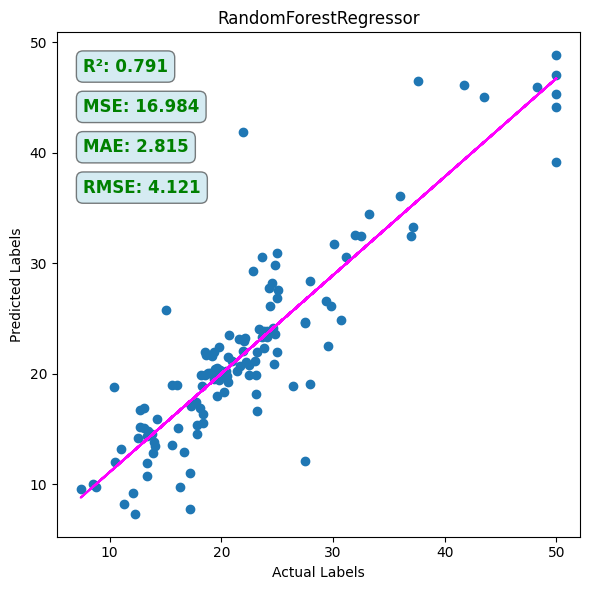

In [20]:
# Train the model
model = RandomForestRegressor().fit(X_train, y_train)
print (model, "\n")

# Evaluate the model using the test data
evaluate_models([model], X_test, y_test)

The Random Forest Regressor slightly improved the R² score.

## Gradient Boosting Regressor

Let's try using a grid search approach to try combinations from a grid of possible values for the learning_rate and n_estimators hyperparameters of the GradientBoostingRegressor estimator.

Best parameter combination: {'learning_rate': 0.1, 'n_estimators': 50} 

GradientBoostingRegressor(n_estimators=50) 



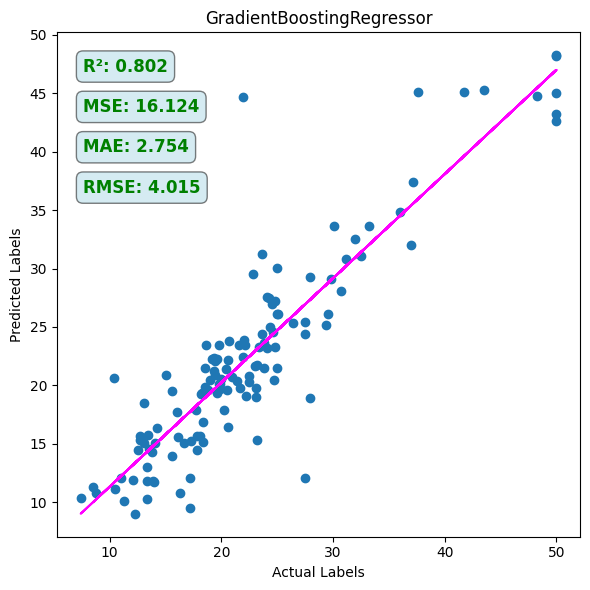

In [21]:
# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Try these hyperparameter values
params = {
 'learning_rate': [0.1, 0.5, 1.0],
 'n_estimators' : [50, 100, 150]
 }

# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, params, scoring=score, cv=3, return_train_score=True)
gridsearch.fit(X_train, y_train)
print("Best parameter combination:", gridsearch.best_params_, "\n")

# Get the best model
model=gridsearch.best_estimator_
print(model, "\n")

# Evaluate the model using the test data
evaluate_models([model], X_test, y_test)

The Gradient Boosting Regressor performs even better, achieving an R² score that explains 80% of the variance in the target variable

# Conclusion

After experimenting with various regression models, both the Random Forest and Gradient Boosting Regressors yielded the best results. The Gradient Boosting Regressor explained around 80% of the target variable's variance, with a prediction error of $2.7K. I hope this work serves as a useful template for solving regression problems. In future updates, I'll add additional steps to enhance accuracy and further improve this notebook as a template.